In [1]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
import pandas as pd
import numpy as np

import CarImageClass

device = "cuda" if torch.cuda.is_available() else "cpu"

# desktop or laptop
machine = 'laptop'

# Setup path to data folder
if machine == 'laptop':
    folder_path = Path(r"C:\self-driving-car\data")
else:
    folder_path = Path(r"D:\Udacity_car_data\data")

train_path = folder_path / "train"
test_path = folder_path / "test"

In [2]:
train_data = CarImageClass.ImageClass(targ_dir=train_path, transform=None, file_pct=1)

Look at some images!

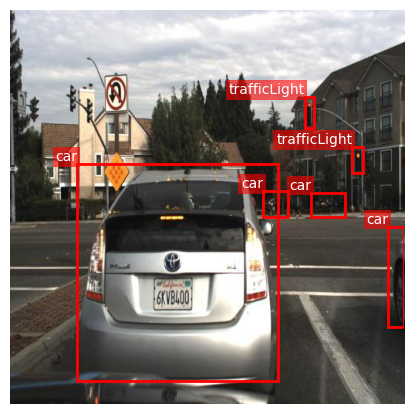

In [3]:
rand_idx = np.random.randint(0, len(train_data))

# set label=False to turn of labels
# set lw=0 to turn off bounding boxes
train_data.show_with_box(index=rand_idx, color='r', lw=2, label=True)

What is the class distribution?

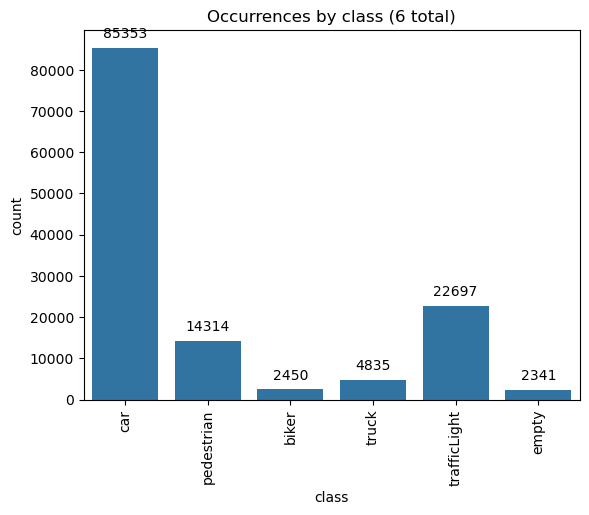

In [4]:
df = train_data.annotate_df

ax = sns.countplot(x=df['class'])

# Annotate counts above each bar
for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(
        str(count), 
        (p.get_x() + p.get_width() / 2., p.get_height()),  # position
        ha='center', va='bottom',                         # alignment
        xytext=(0, 5), textcoords='offset points'         # offset above bar
    )

plt.xticks(rotation=90)
plt.title(f"Occurrences by class ({len(df['class'].unique())} total)")
plt.show()

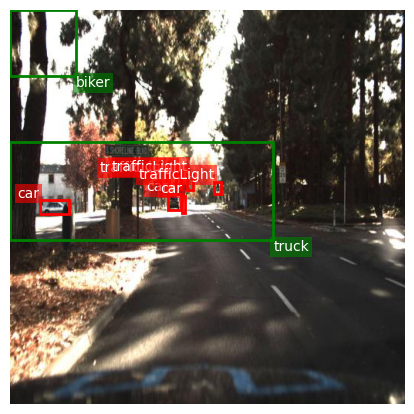

In [5]:
test_pred = {"labels": [0, 4], "boxes": torch.tensor([[0,0,50,50],[0,100,200,175]])}

train_data.show_with_box(index=106, color='r', lw = 2, label=True, pred_dict=test_pred, pred_color='g', lw_pred=2, pred_label=True)